In [1]:
import os, tempfile
import logging
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ical_li import (li_act,
                                 li_inact_1000)
from experiments.ical_sun import sun_inact_kin_slow

In [6]:
modelfile = 'models/courtemanche_ical.mmt'

## Plot steady-state and tau functions

In [7]:
from ionchannelABC.visualization import plot_variables

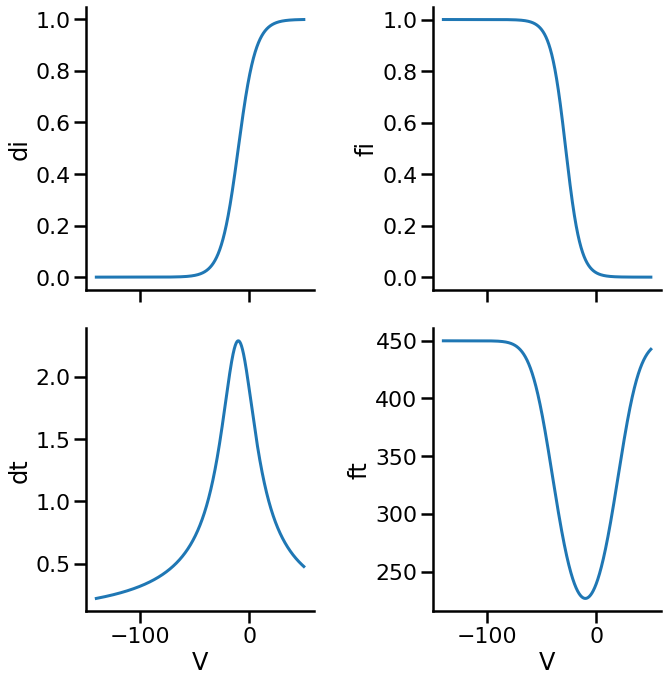

In [9]:
sns.set_context('poster')

V = np.arange(-140, 50, 0.01)

cou_vars = {'di': 'ical.d_inf',
            'fi': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'ft': 'ical.tau_f'}

f, ax = plot_variables(V, cou_vars, 'models/courtemanche_ical.mmt', figshape=(2,2))

# d gate -> Only activation data

In [10]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act)

In [11]:
assert len(observations)==len(summary_statistics(model({})))

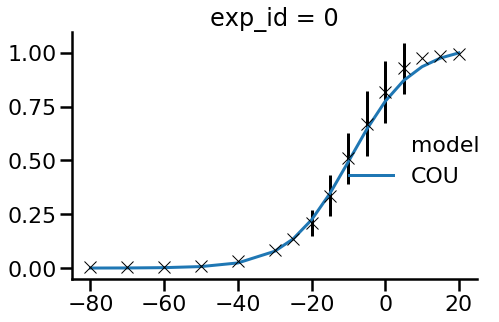

In [12]:
g = plot_sim_results(modelfile,
                     li_act)

In [13]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50)}
          #'ical.q1': (0, 100),
          #'ical.q2': (0, 50),
          #'log_ical.q3': (-2, 0),
          #'ical.q4': (0, 100),
          #'ical.q5': (0, 50),
          #'log_ical.q6': (-3, -1),
          #'log_ical.r1': (-1, 1),
          #'ical.r2': (0, 100),
          #'ical.r3': (0, 100),
          #'log_ical.r4': (-3, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [14]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ical_dgate_reported.db"))

In [15]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [16]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [17]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2446079782705148, '1': 1.2446079782705148, '2': 1.2446079782705148, '3': 1.2446079782705148, '4': 1.2446079782705148, '5': 1.2446079782705148, '6': 1.2446079782705148, '7': 1.042671915141306, '8': 0.6364361040472902, '9': 0.5199531035717904, '10': 0.40923240093228713, '11': 0.42429073603152656, '12': 0.521335957570653, '13': 1.2446079782705148, '14': 1.2446079782705148, '15': 1.2446079782705148}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [18]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [19]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-17 13:46:20.011046, end_time=None)>


In [20]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2026
DEBUG:Epsilon:new eps, t=1, eps=1.5249660839874908
INFO:ABC:t:1 eps:1.5249660839874908
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 5820
DEBUG:Epsilon:new eps, t=2, eps=0.8672636047163372
INFO:ABC:t:2 eps:0.8672636047163372
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 9851
DEBUG:Epsilon:new eps, t=3, eps=0.6122752469319943
INFO:ABC:t:3 eps:0.6122752469319943
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 14317
DEBUG:Epsilon:new eps, t=4, eps=0.5053136055782594
INFO:ABC:t:4 eps:0.5053136055782594
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 19089
DEBUG:Epsilon:new eps, t=5, eps=0.4381834471

### Database results analysis

In [21]:
history = History(db_path)

In [22]:
df, w = history.get_distribution(m=0)

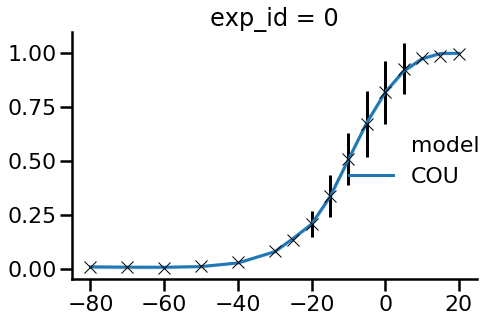

In [23]:
g = plot_sim_results(modelfile,
                     li_act,
                     df=df, w=w)

In [24]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

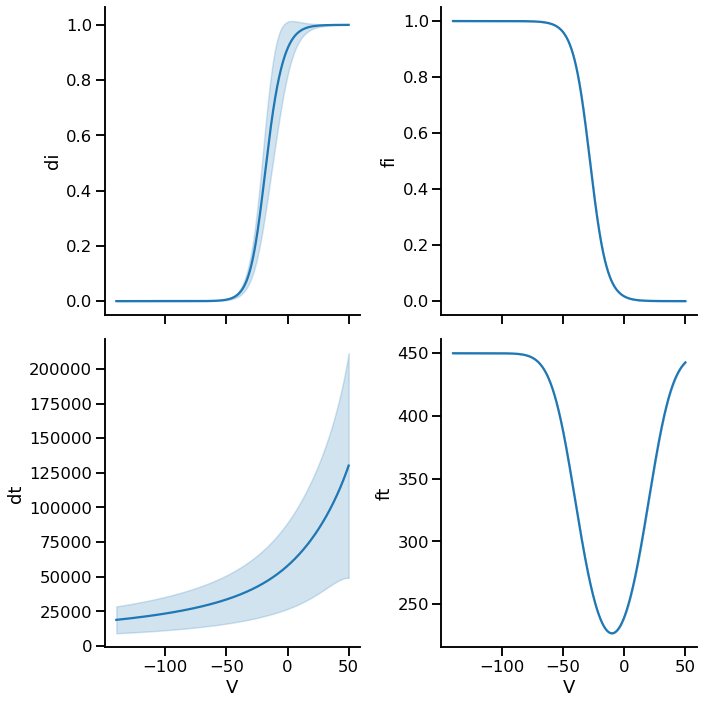

In [25]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ical.mmt', 
                       [cou_pars],
                       figshape=(2,2))

In [26]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [27]:
m,_,_ = myokit.load(modelfile)

In [28]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

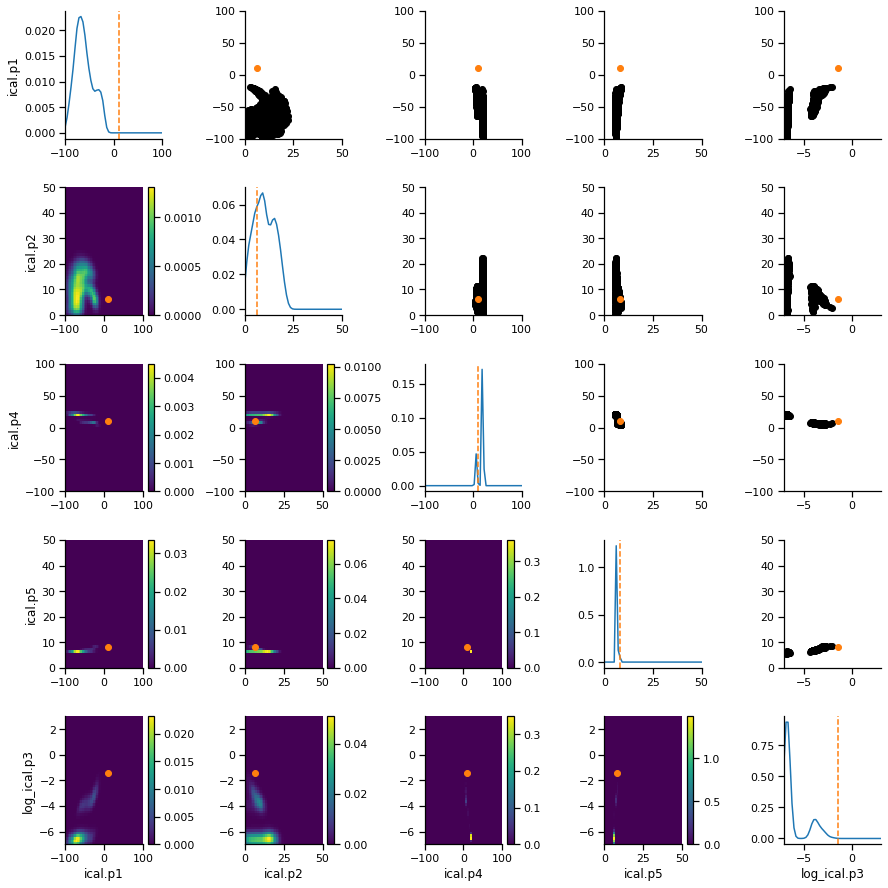

In [29]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# f gate -> Inactivation

In [30]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                sun_inact_kin_slow)

In [31]:
assert len(observations)==len(summary_statistics(model({})))

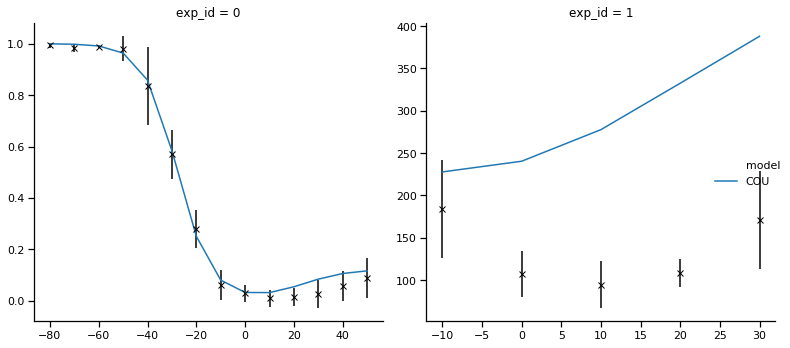

In [32]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     sun_inact_kin_slow)

In [33]:
limits = {#'ical.p1': (-50, 50),
          #'ical.p2': (0, 50),
          #'log_ical.p3': (-7, 3),
          #'ical.p4': (0, 100),
          #'ical.p5': (0, 50),
          #'log_ical.p6': (-7, 3)}
          'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [34]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ical_fgate_reported.db"))

In [35]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [36]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [37]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.176132058445145, '1': 1.176132058445145, '2': 1.176132058445145, '3': 1.176132058445145, '4': 0.3892784268190627, '5': 0.604405978482229, '6': 0.8074486118786046, '7': 1.0034312846646722, '8': 1.176132058445145, '9': 1.176132058445145, '10': 1.176132058445145, '11': 1.0995044927708642, '12': 1.0034312846646722, '13': 0.7544045424851181, '14': 0.5263305611568131, '15': 1.104247498336103, '16': 1.1063428446327512, '17': 1.8421569640488558, '18': 0.5260931009442432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [38]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [39]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-17 15:25:47.936468, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 10309
DEBUG:Epsilon:new eps, t=1, eps=8.705169594851025
INFO:ABC:t:1 eps:8.705169594851025
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 15452
DEBUG:Epsilon:new eps, t=2, eps=2.1686344483401947
INFO:ABC:t:2 eps:2.1686344483401947
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 20832
DEBUG:Epsilon:new eps, t=3, eps=1.4965119735542094
INFO:ABC:t:3 eps:1.4965119735542094
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 28119
DEBUG:Epsilon:new eps, t=4, eps=1.153585553861291
INFO:ABC:t:4 eps:1.153585553861291
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 36782
DEBUG:Epsilon:new eps, t=5, eps=0.87650805788

### Database results analysis

In [41]:
history = History(db_path)

In [42]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-17 15:25:47.936468, end_time=2019-10-17 19:38:25.461218)>]

In [43]:
df, w = history.get_distribution(m=0)

In [44]:
df.describe()

name,ical.q4,ical.q6,ical.q7,log_ical.q1,log_ical.q2,log_ical.q3,log_ical.q5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-15.703341,27.702654,7.340350,1.590756,-0.481084,-2.109852,-1.782001
std,35.742192,1.485608,1.000522,0.710907,0.847052,0.803497,1.038426
min,-99.905497,22.728886,3.534692,0.028940,-1.989594,-3.995052,-3.996133
25%,-32.662145,26.862679,6.779595,1.047811,-1.141645,-2.601428,-2.579144
50%,-14.199977,27.544204,7.320581,1.630087,-0.499407,-1.947088,-1.666768
75%,-5.441050,28.246457,7.836125,2.125888,0.123311,-1.600957,-0.935848
max,99.841123,35.207710,12.626933,2.996731,2.871118,-0.007737,-0.004483


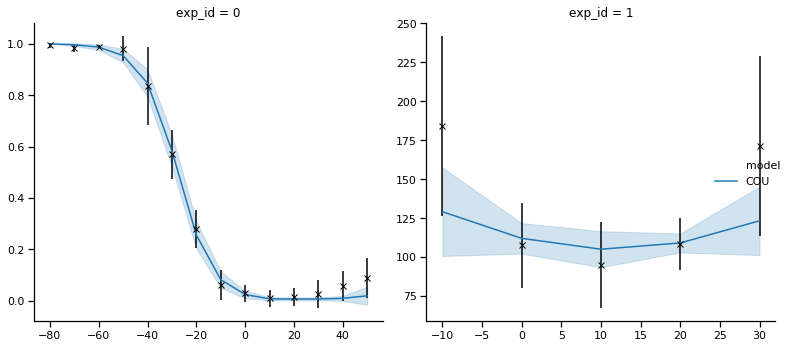

In [45]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     sun_inact_kin_slow,
                     df=df, w=w)

In [46]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [47]:
m,_,_ = myokit.load(modelfile)

In [48]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

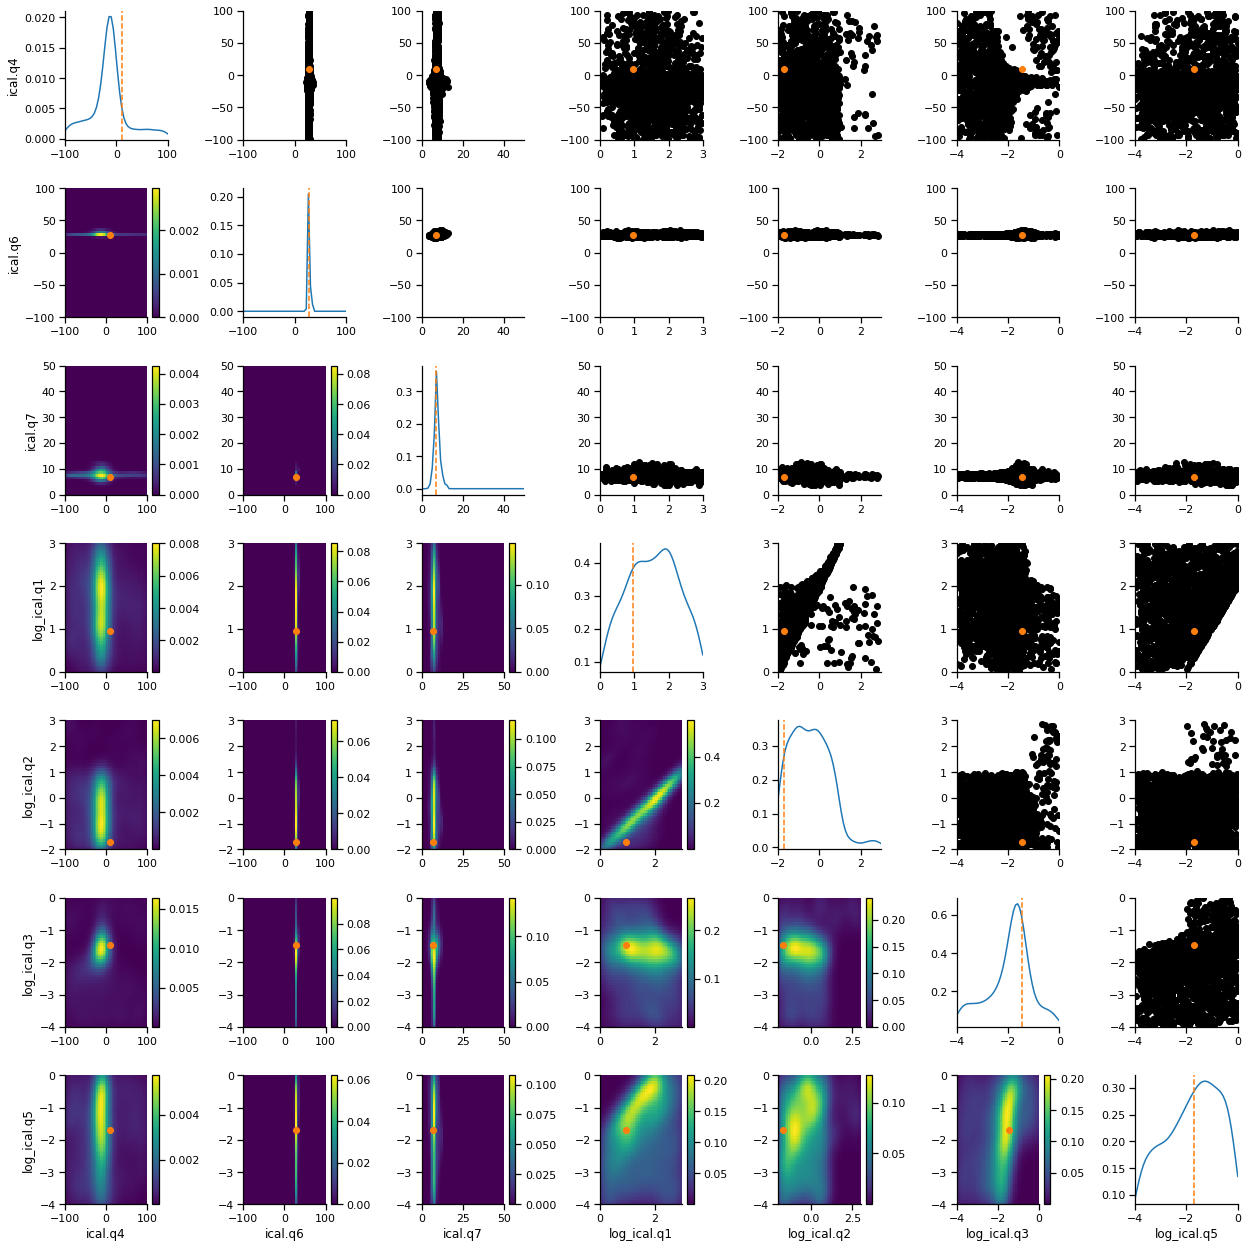

In [49]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [50]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

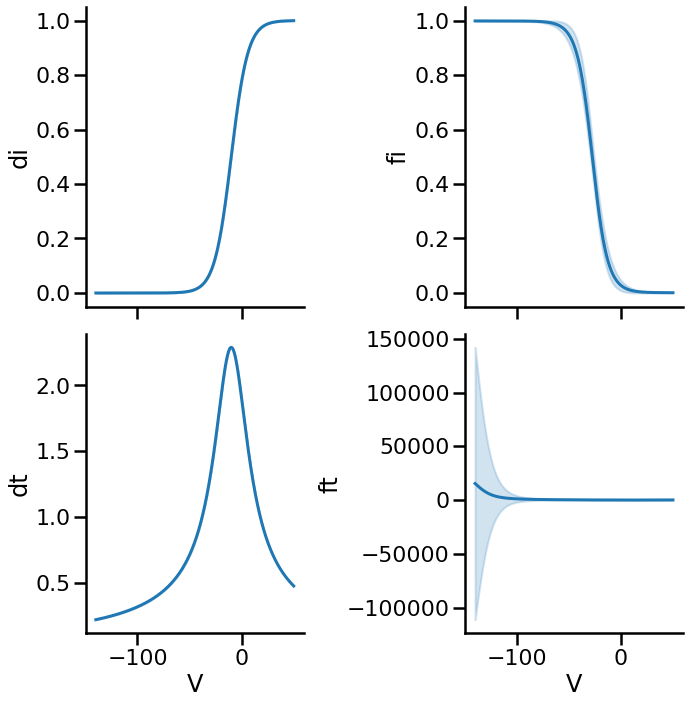

In [51]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ical.mmt', 
                       [cou_pars],
                       figshape=(2,2))

## Full calibration

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act,
                                                li_inact_1000,
                                                sun_inact_kin_slow)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

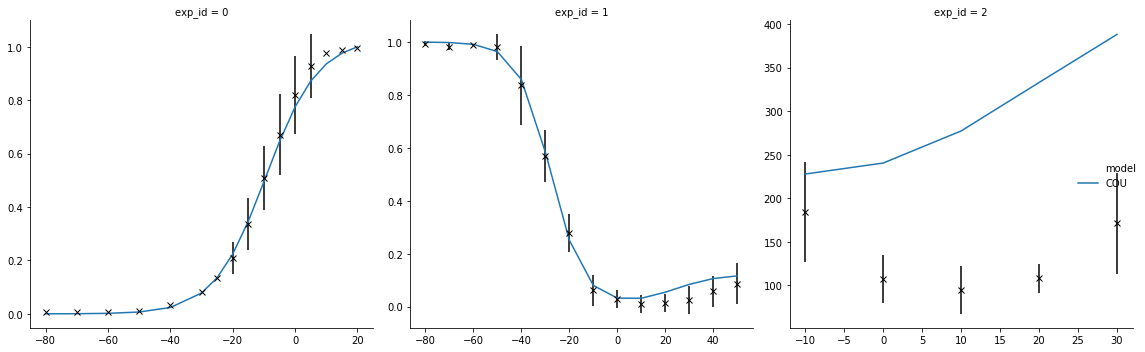

In [8]:
g = plot_sim_results(modelfile,
                     li_act,
                     li_inact_1000,
                     sun_inact_kin_slow)

In [9]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (0, 100),
          'ical.p5': (0, 50),
          'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50),
          'ical.E_Ca_app': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ical_reported.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 8192 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.1175714210172887, '1': 1.1175714210172887, '2': 1.1175714210172887, '3': 1.1175714210172887, '4': 1.1175714210172887, '5': 1.1175714210172887, '6': 1.1175714210172887, '7': 0.9362468778952489, '8': 0.5714753670269697, '9': 0.466881732213014, '10': 0.3674622401760058, '11': 0.38098357801797955, '12': 0.4681234389476244, '13': 1.1175714210172887, '14': 1.1175714210172887, '15': 1.1175714210172887, '16': 1.2772244811626154, '17': 1.2772244811626154, '18': 1.2772244811626154, '19': 1.2772244811626154, '20': 0.4227381892634345, '21': 0.6563566622774378, '22': 0.8768514785112667, '23': 1.0896795072761356, '24': 1.2772244811626154, '25': 1.2772244811626154, '26': 1.2772244811626154, '27': 1.1940105239302334, '28': 1.0896795072761356, '29': 0.8192480967112548, '30': 0.5715704057776028, '31': 1.1991612064396637, '32': 1.2014366546492214, '33': 2.0004964202216207, '34': 0.5713125350779492}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_mu

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-10 12:57:03.478019, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 9714
DEBUG:Epsilon:new eps, t=1, eps=7.1700072887219815
INFO:ABC:t:1 eps:7.1700072887219815
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 14994
DEBUG:Epsilon:new eps, t=2, eps=3.239403757841662
INFO:ABC:t:2 eps:3.239403757841662
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 21008
DEBUG:Epsilon:new eps, t=3, eps=2.6548959560533683
INFO:ABC:t:3 eps:2.6548959560533683
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 28684
DEBUG:Epsilon:new eps, t=4, eps=2.247455140340947
INFO:ABC:t:4 eps:2.247455140340947
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 37201
DEBUG:Epsilon:new eps, t=5, eps=1.916458875009

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

In [17]:
history = History(db_path)

In [18]:
df, w = history.get_distribution(m=0)

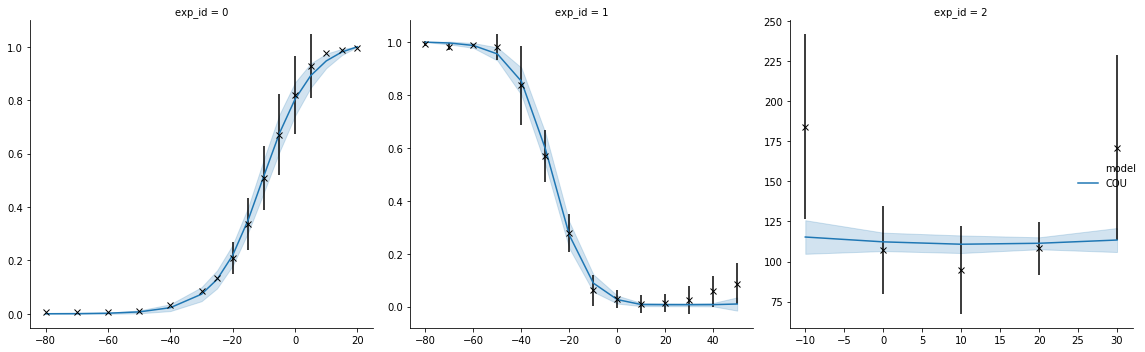

In [19]:
g = plot_sim_results(modelfile,
                     li_act,
                     li_inact_1000,
                     sun_inact_kin_slow,
                     df=df, w=w)

In [20]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [21]:
m,_,_ = myokit.load(modelfile)

In [22]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

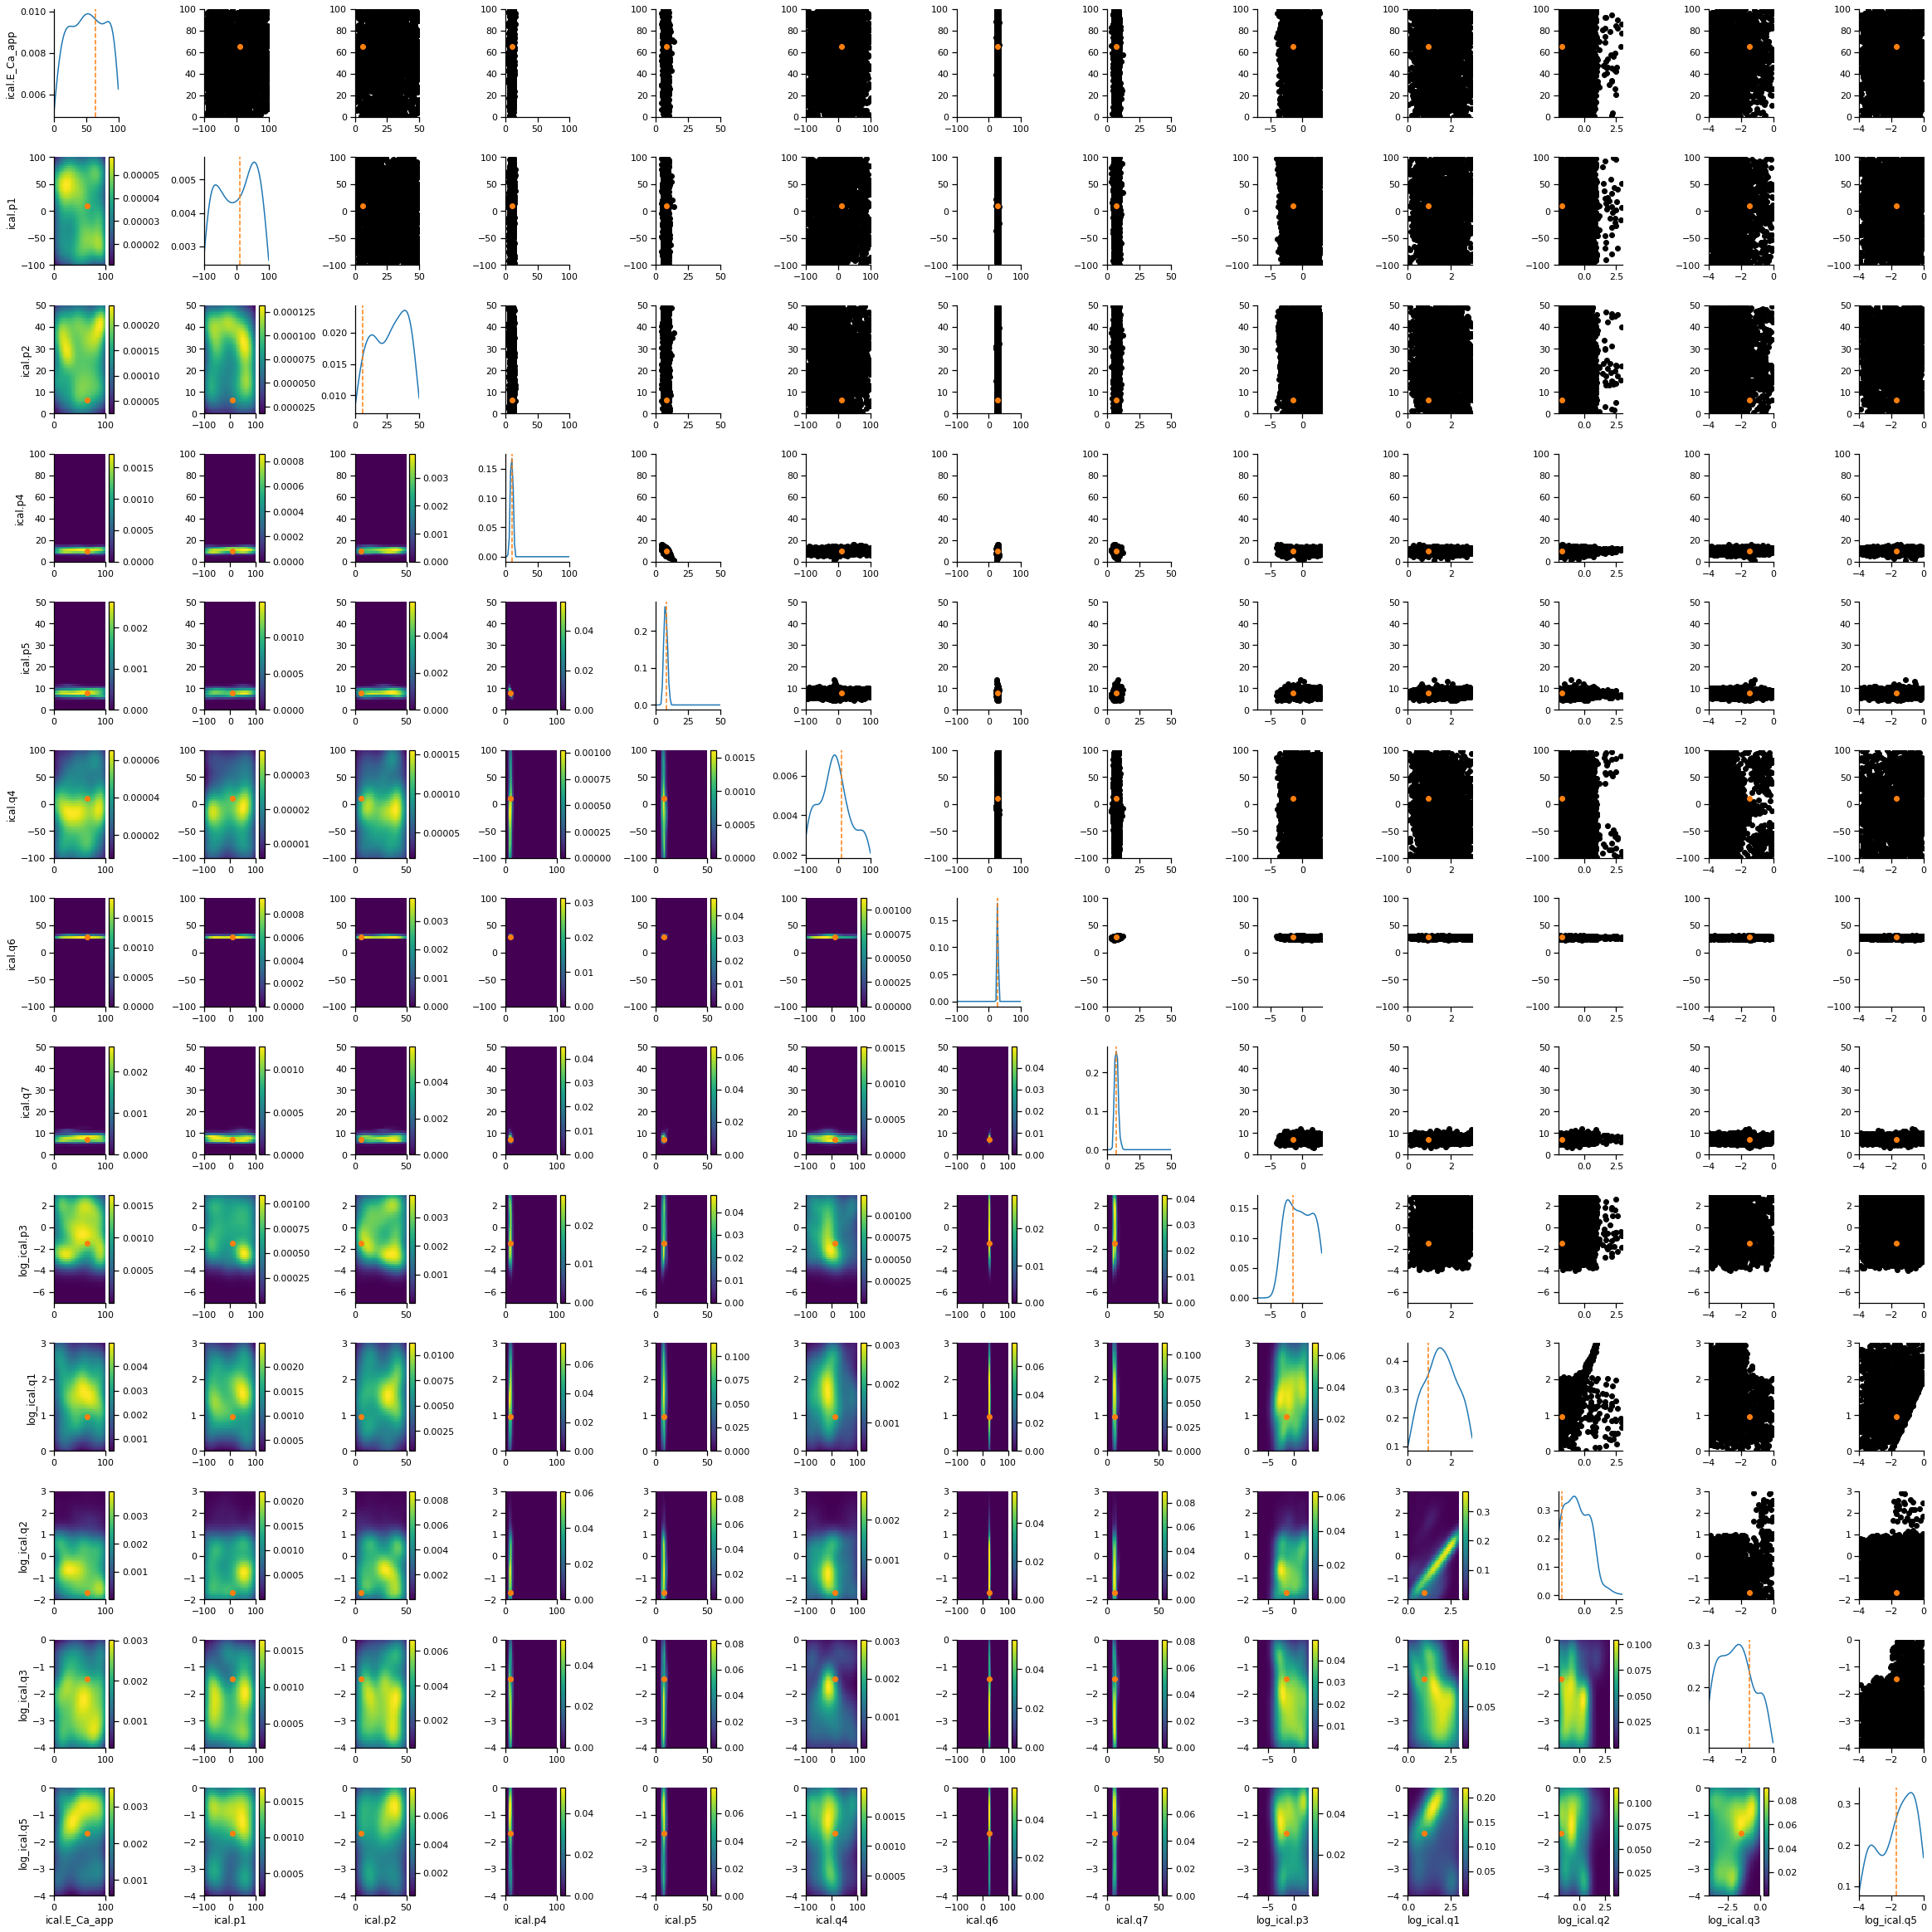

In [23]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [24]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

In [26]:
from ionchannelABC.visualization import plot_variables

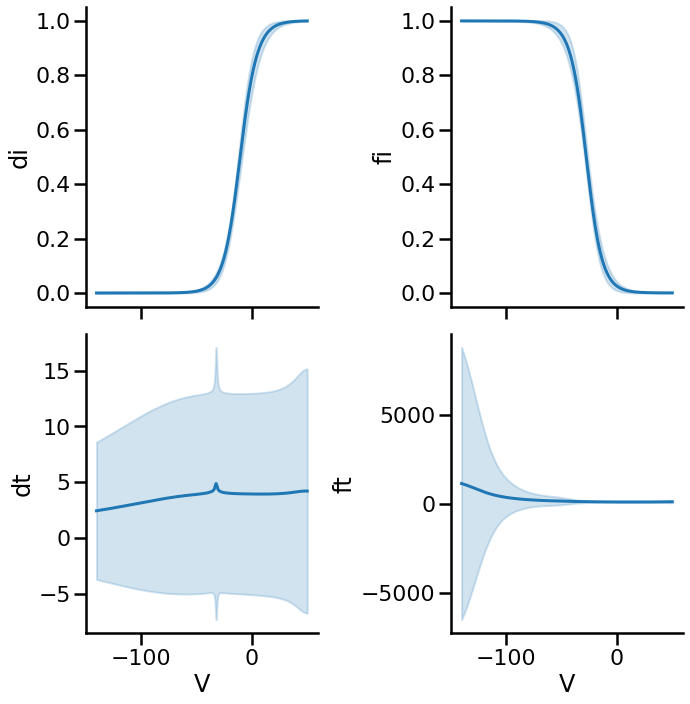

In [30]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-140, 50, 0.01)

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ical.mmt', 
                       [cou_pars],
                       figshape=(2,2))